In [40]:
import nptsne
from nptsne import hsne_analysis
from pathlib import Path
import numpy as np
import community as community_louvain
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
from matplotlib.lines import Line2D
import pandas as pd
from tqdm import tqdm
from sklearn.utils import check_random_state, check_array
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA


fashionTrain = pd.read_csv('data/fashion-train.csv')

fashionX = fashionTrain.values[:,2:]
fashionY = fashionTrain.values[:, 1].astype(int)

print(fashionX.shape, fashionY.shape)

X = fashionX
X = normalize(X)
lab = fashionY.astype(int)




# X = np.load('./data/MNIST_35000.npy')
# lab = np.load('./data/MNIST_35000_label.npy').astype(int)
# X = normalize(X)


# data = pd.read_csv('data/mnist_max_pooling2d_dense.data', header=None)
# data = data.drop(columns=[0])
# X = data.values[:, :-1]
# lab = data.values[:, -1]


X = np.loadtxt("data/mammals-20000_features.txt")
lab = np.loadtxt("data/mammals-20000_classes.txt")



# data = pd.read_csv('data/gene_expression.csv')
# X = data.values[:, :-1]
# lab = data.values[:, -1]
# X = np.log(X+1)
# # X = normalize(X)
# X = PCA(n_components=100).fit_transform(X)






X = check_array(X, dtype=np.float32, accept_sparse="csr", order="C")
dataset = 'fashion'
print('Size data:', X.shape)

(60000, 784) (60000,)
Size data: (20000, 71)


In [41]:
hsne = nptsne.HSne(True)
# Create a 3 scale HSNE analysis from the MNIST data
hsne.create_hsne(X, 3)
# print(hsne.get_scale(0).num_points, hsne.get_scale(1).num_points)
print(hsne.get_scale(0).num_points, hsne.get_scale(1).num_points, hsne.get_scale(2).num_points)
# print(hsne.get_scale(0).num_points, hsne.get_scale(1).num_points, hsne.get_scale(2).num_points, hsne.get_scale(3).num_points)



20000 3740 646


In [58]:
container = hsne_analysis.AnalysisModel(hsne, hsne_analysis.EmbedderType.CPU)

In [59]:
analysis_level3 = container.top_analysis
len(analysis_level3.landmark_orig_indexes)

646

In [60]:
for i in tqdm(range(500)):
    analysis_level3.do_iteration()

100%|██████████| 500/500 [00:02<00:00, 188.62it/s]


In [61]:
y_analysis_level3 = lab[analysis_level3.landmark_orig_indexes]

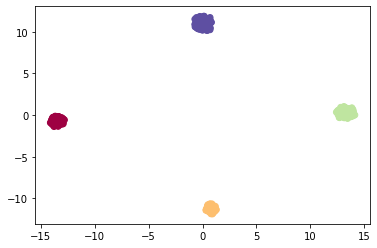

In [62]:
plt.scatter(analysis_level3.embedding[:, 0], analysis_level3.embedding[:, 1], 
            c = y_analysis_level3, cmap='Spectral')
plt.savefig('figs/'+dataset+'-hsne-level3.png')

In [63]:
analysis_level2 = container.add_new_analysis(analysis_level3, np.arange(len(y_analysis_level3)))
len(analysis_level2.landmark_orig_indexes)

3740

In [64]:
for i in tqdm(range(500)):
    analysis_level2.do_iteration()

100%|██████████| 500/500 [00:23<00:00, 20.97it/s]


In [65]:
y_analysis_level2 = lab[analysis_level2.landmark_orig_indexes]
len(y_analysis_level2)

3740

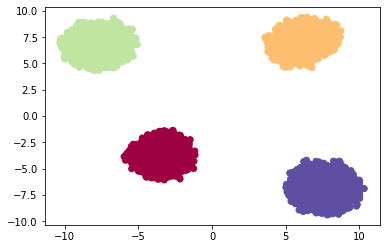

In [66]:
plt.scatter(analysis_level2.embedding[:, 0], analysis_level2.embedding[:, 1], 
            c = y_analysis_level2, cmap='Spectral')
plt.savefig('figs/'+dataset+'-hsne-level2.png')
# inds = y_analysis_level2 == 2
# plt.scatter(analysis_level2.embedding[inds, 0], analysis_level2.embedding[inds, 1], 
#             c = 'black', s=10)
# plt.savefig("hsne_level2.svg")
# plt.show()

In [17]:
analysis_level1 = container.add_new_analysis(analysis_level2, np.arange(len(y_analysis_level2)))
len(analysis_level1.landmark_orig_indexes)

14418

In [18]:
for i in tqdm(range(500)):
    analysis_level1.do_iteration()

100%|██████████| 500/500 [00:01<00:00, 491.33it/s]


In [19]:
y_analysis_level1 = lab[analysis_level1.landmark_orig_indexes]
len(y_analysis_level1)

14418

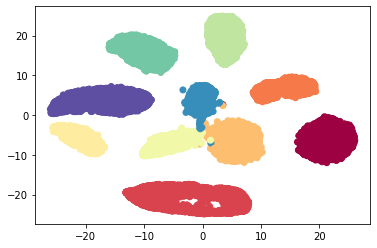

In [20]:
plt.scatter(analysis_level1.embedding[:, 0], analysis_level1.embedding[:, 1], 
            c = y_analysis_level1, cmap='Spectral')
plt.savefig("figs/"+dataset+"-hsne-level1.png")

In [21]:
analysis_level0 = container.add_new_analysis(analysis_level1, np.arange(len(y_analysis_level1)))
len(analysis_level0.landmark_orig_indexes)

70000

In [22]:
for i in tqdm(range(500)):
    analysis_level0.do_iteration()

100%|██████████| 500/500 [00:02<00:00, 168.37it/s]


In [23]:
y_analysis_level0 = lab[analysis_level0.landmark_orig_indexes]
y_analysis_level0

array([0, 0, 0, ..., 9, 9, 9])

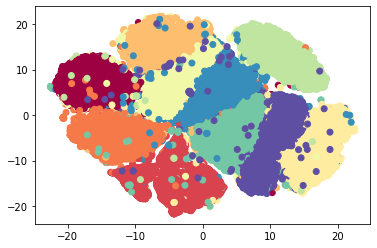

In [24]:
plt.scatter(analysis_level0.embedding[:, 0], analysis_level0.embedding[:, 1], c = y_analysis_level0, 
            cmap='Spectral')
plt.savefig("figs/"+dataset+"-hsne-level0.png")
# plt.savefig("hsne_level0.svg")
# plt.show()

In [67]:
indices = []
for i in range(len(y_analysis_level3)):
    if y_analysis_level3[i] in [0, 1]:
        indices.append(i)


analysis_cluster1 = container.add_new_analysis(analysis_level3, np.array(indices))
# len(analysis_cluster.landmark_orig_indexes), analysis_cluster.landmark_orig_indexes

In [68]:
for i in tqdm(range(500)):
    analysis_cluster1.do_iteration()

100%|██████████| 500/500 [00:31<00:00, 15.84it/s]


In [69]:
y_analysis_cluster1 = lab[analysis_cluster1.landmark_orig_indexes]
len(y_analysis_cluster1)

1816

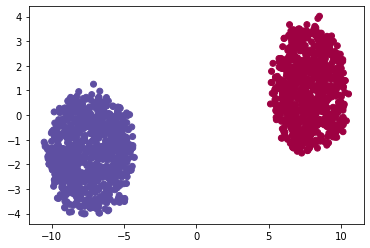

In [70]:
plt.scatter(analysis_cluster1.embedding[:, 0], analysis_cluster1.embedding[:, 1],
            c = y_analysis_cluster1, cmap='Spectral')
plt.savefig("figs/"+dataset+"-hsne-expand1.png")

In [71]:
# indices = []
# for i in range(len(y_analysis_level2)):
#     if y_analysis_level2[i] in [5,7,9]:
#         indices.append(i)


analysis_cluster = container.add_new_analysis(analysis_cluster1, np.arange(len(y_analysis_cluster1)))
# len(analysis_cluster.landmark_orig_indexes), analysis_cluster.landmark_orig_indexes

In [72]:
for i in tqdm(range(500)):
    analysis_cluster.do_iteration()

100%|██████████| 500/500 [00:43<00:00, 11.54it/s]


In [73]:
y_analysis_cluster = lab[analysis_cluster.landmark_orig_indexes]
len(y_analysis_cluster)

10002

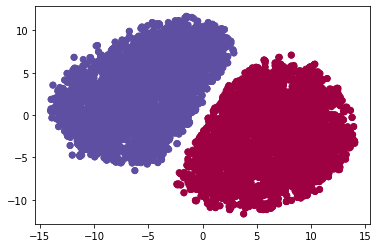

In [74]:
plt.scatter(analysis_cluster.embedding[:, 0], analysis_cluster.embedding[:, 1],
            c = y_analysis_cluster, cmap='Spectral')
plt.savefig("figs/"+dataset+"-hsne-expand2.png")

In [33]:
# indices = []
# for i in range(len(y_analysis_level1)):
#     if y_analysis_level1[i] in [5,7,9]:
#         indices.append(i)


analysis_cluster0 = container.add_new_analysis(analysis_cluster, np.arange(len(y_analysis_cluster)))#np.array(indices))


In [34]:
for i in tqdm(range(500)):
    analysis_cluster0.do_iteration()

100%|██████████| 500/500 [00:00<00:00, 1041.24it/s]


In [35]:
y_analysis_cluster0 = lab[analysis_cluster0.landmark_orig_indexes]

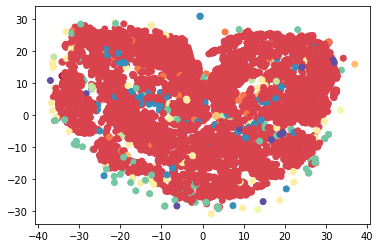

In [36]:
plt.scatter(analysis_cluster0.embedding[:, 0], analysis_cluster0.embedding[:, 1], 
            c = y_analysis_cluster0, cmap='Spectral')
plt.savefig("figs/"+dataset+"-hsne-expand3.png")

In [36]:
import demap
import random
import math
from sklearn.metrics import euclidean_distances

from sklearn.neighbors import NearestNeighbors

from scipy.stats import pearsonr

def correlation(X, X_emb):
    
    high = []
    emb = []
    
    for i in range(X.shape[0]):
        for j in range(i+1, X.shape[0]):
            high.append(np.linalg.norm(X[i]-X[j]))
            emb.append(np.linalg.norm(X_emb[i]-X_emb[j]))
    
    high = np.array(high)
    emb = np.array(emb)
    
    return pearsonr(high, emb)[0]

def stress(X, X_emb):
    
#     num = 0.0
#     den = 0.0
    
#     for i in range(X.shape[0]):
#         for j in range(X.shape[0]):
#             num += (np.linalg.norm(X[i]-X[j]) - np.linalg.norm(X_emb[i]-X_emb[j]))**2
            
#             den += np.linalg.norm(X_emb[i]-X_emb[j])**2
            
#     return math.sqrt(num/den)
    
    
    
    DE = euclidean_distances(X_emb)
    DE = DE/np.max(DE)
    DH = euclidean_distances(X)
    DH = DH/np.max(DH)
    stress = 0.5 * np.sum((DE - DH)**2)
    
    return np.sqrt(stress/(0.5*np.sum(DH**2)))
    

    

def NNP(X, X_emb, Khigh=30):
    neigh_high = NearestNeighbors(n_neighbors=Khigh, n_jobs=-1)
    neigh_high.fit(X)
    high_dists, high_indices = neigh_high.kneighbors(X)


    neigh_emb = NearestNeighbors(n_neighbors=Khigh, n_jobs=-1)
    neigh_emb.fit(X_emb)
    emb_dists, emb_indices = neigh_emb.kneighbors(X_emb)

    m_precision = np.zeros(Khigh)
    m_recall = np.zeros(Khigh)
    
    for i in tqdm(range(X.shape[0])):
        high_current = high_indices[i][1:]
        for k in range(1, Khigh+1):
            emb_current = emb_indices[i][1:k+1]            
            
            tp = len(np.intersect1d(high_current, emb_current))
            
            precision_val = float(tp)/k
            recall_val = float(tp)/Khigh
            
            m_precision[k-1] += precision_val
            m_recall[k-1] += recall_val
    
    m_precision = m_precision/float(X.shape[0])
    m_recall = m_recall/float(X.shape[0])
    
            
    return m_precision, m_recall


def neighborhood_preservation(X, X_emb, Khigh=30):
    
    neigh_high = NearestNeighbors(n_neighbors=Khigh+1, n_jobs=-1)
    neigh_high.fit(X)
    high_dists, high_indices = neigh_high.kneighbors(X)


    neigh_emb = NearestNeighbors(n_neighbors=Khigh+1, n_jobs=-1)
    neigh_emb.fit(X_emb)
    emb_dists, emb_indices = neigh_emb.kneighbors(X_emb)

    npres = np.zeros(Khigh)
    
    for k in range(1, Khigh+1):
        for i in range(X.shape[0]):
            high_current = high_indices[i][1:k+1]
            emb_current = emb_indices[i][1:k+1]
            
            tp = len(np.intersect1d(high_current, emb_current))
            
            npres[k-1] += (tp/k)
        
        
    npres /= float(X.shape[0])
    
    return npres
    
    


stress:  0.489960396024989
demap:  0.7554567338939292
pearsonr:  0.6995091452392204
[0.08513932 0.11068111 0.13673891 0.15944272 0.17801858 0.1999484
 0.22158337 0.23935759 0.25730994 0.27832817 0.29890234 0.31695046
 0.32960229 0.34475896 0.35944272 0.375387   0.38963759 0.40376677
 0.41665309 0.42941176 0.44073419 0.45151984 0.4646655  0.47639319
 0.48767802 0.49779709 0.50630662 0.51719372 0.52663606 0.5368937 ]


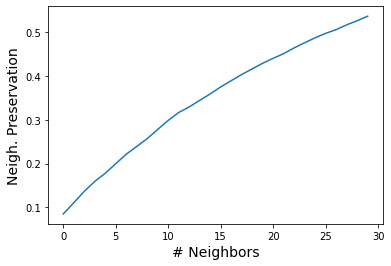

In [75]:
fourth_level = X[analysis_level3.landmark_orig_indexes,:]
fourth_embedding = analysis_level3.embedding

indices_4 = random.sample(range(0, len(fourth_embedding)), min(3000, len(fourth_embedding)))

fourth_embedding = fourth_embedding[indices_4]
fourth_level = fourth_level[indices_4]



noise = np.random.normal(0, .1, fourth_level.shape)
print("stress: ", stress(fourth_level, fourth_embedding))
print("demap: ", demap.DEMaP(fourth_level, fourth_embedding))
print("pearsonr: ", correlation(fourth_level, fourth_embedding))


ks = 30

npres = neighborhood_preservation(fourth_level, fourth_embedding, Khigh=ks)
print(npres)
plt.plot(np.arange(ks), npres)
plt.xlabel("# Neighbors", fontsize=14)
plt.ylabel("Neigh. Preservation", fontsize=14)
plt.savefig("figs/"+dataset+"-hsne-level3-np.png")
plt.show()

stress:  0.5306937974306045
demap:  0.7487363018661585
pearsonr:  0.5185754622655951
[0.107      0.09333333 0.09622222 0.10291667 0.10813333 0.11522222
 0.11957143 0.12495833 0.13148148 0.13846667 0.14436364 0.14961111
 0.15551282 0.16019048 0.16673333 0.1716875  0.17713725 0.18203704
 0.18670175 0.19136667 0.19542857 0.19956061 0.20391304 0.20919444
 0.2136     0.21741026 0.22076543 0.22444048 0.22836782 0.2322    ]


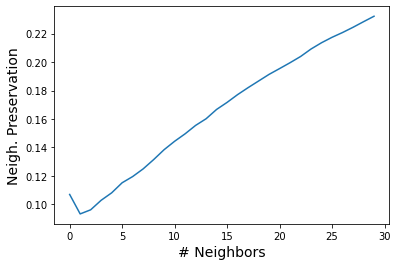

In [76]:

third_level = X[analysis_level2.landmark_orig_indexes,:]
third_embedding = analysis_level2.embedding

indices_3 = random.sample(range(0, len(third_embedding)), min(3000, len(third_embedding)))

third_embedding = third_embedding[indices_3]
third_level = third_level[indices_3]


noise = np.random.normal(0, .1, third_level.shape)
print("stress: ", stress(third_level, third_embedding))
print("demap: ", demap.DEMaP(third_level, third_embedding))
print("pearsonr: ", correlation(third_level, third_embedding))


ks = 30

npres = neighborhood_preservation(third_level, third_embedding, Khigh=ks)
print(npres)
plt.plot(np.arange(ks), npres)
plt.xlabel("# Neighbors", fontsize=14)
plt.ylabel("Neigh. Preservation", fontsize=14)
plt.savefig("figs/"+dataset+"-hsne-level2-np.png")
plt.show()

In [77]:

second_level = X[analysis_level1.landmark_orig_indexes,:]
second_embedding = analysis_level1.embedding


indices_2 = random.sample(range(0, len(second_embedding)), min(3000, len(second_embedding)))

second_embedding = second_embedding[indices_2]
second_level = second_level[indices_2]


print("stress: ", stress(second_level, second_embedding))
print("demap: ", demap.DEMaP(second_level, second_embedding))
print("pearsonr: ", correlation(second_level, second_embedding))


npres = neighborhood_preservation(second_level, second_embedding, Khigh=ks)
print(npres)
plt.plot(np.arange(ks), npres)
plt.xlabel("# Neighbors", fontsize=14)
plt.ylabel("Neigh. Preservation", fontsize=14)
plt.savefig("figs/"+dataset+"-hsne-level1-np.png")
plt.show()

NameError: name 'analysis_level1' is not defined

In [ ]:

first_level = X[analysis_level0.landmark_orig_indexes,:]
first_embedding = analysis_level0.embedding


indices_1 = random.sample(range(0, len(first_embedding)), min(3000, len(first_embedding)))

first_embedding = first_embedding[indices_1]
first_level = first_level[indices_1]

print("stress: ", stress(first_level, first_embedding))
print("demap: ", demap.DEMaP(first_level, first_embedding))
print("pearsonr: ", correlation(first_level, first_embedding))

npres = neighborhood_preservation(first_level, first_embedding, Khigh=ks)
print(npres)
plt.plot(np.arange(ks), npres)
plt.xlabel("# Neighbors", fontsize=14)
plt.ylabel("Neigh. Preservation", fontsize=14)
plt.savefig("figs/"+dataset+"-hsne-level0-np.png")
plt.show()

stress:  0.15256731181723804
demap:  0.8521829165067053
pearsonr:  0.9750146418337774
[0.12389868 0.10930617 0.10407489 0.11040749 0.11376652 0.12050294
 0.12460667 0.13174559 0.14115272 0.1470815  0.15278334 0.15909508
 0.16341918 0.16869887 0.17243025 0.17600496 0.17990412 0.18404307
 0.18803617 0.19162996 0.19503881 0.19873849 0.20290653 0.20535059
 0.20909692 0.21276686 0.21543074 0.21784534 0.22043521 0.2239721 ]


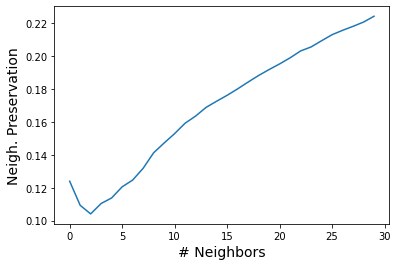

In [78]:
cluster_level = X[analysis_cluster1.landmark_orig_indexes,:]
cluster_embedding = analysis_cluster1.embedding

indices_cluster = random.sample(range(0, len(cluster_embedding)), min(5000, len(cluster_embedding)))

cluster_embedding = cluster_embedding[indices_cluster]
cluster_level = cluster_level[indices_cluster]

print("stress: ", stress(cluster_level, cluster_embedding))
print("demap: ", demap.DEMaP(cluster_level, cluster_embedding))
print("pearsonr: ", correlation(cluster_level, cluster_embedding))

ks = 30

npres = neighborhood_preservation(cluster_level, cluster_embedding, Khigh=ks)
print(npres)
plt.plot(np.arange(ks), npres)
plt.xlabel("# Neighbors", fontsize=14)
plt.ylabel("Neigh. Preservation", fontsize=14)
plt.savefig("figs/"+dataset+"-hsne-expand1-np.png")
plt.show()

stress:  0.3780030344994095
demap:  0.7154367142252872
pearsonr:  0.6710445922295839
[0.1954     0.1897     0.19406667 0.1976     0.1992     0.20026667
 0.20131429 0.20165    0.2024     0.2024     0.20234545 0.20181667
 0.20169231 0.20175714 0.20236    0.2026     0.20215294 0.20294444
 0.20314737 0.20335    0.20299048 0.20334545 0.20367826 0.20349167
 0.20384    0.20411538 0.2046     0.20507857 0.20531034 0.20523333]


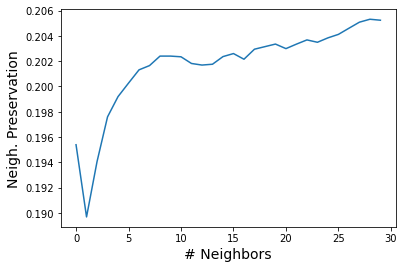

In [79]:
cluster_level = X[analysis_cluster.landmark_orig_indexes,:]
cluster_embedding = analysis_cluster.embedding

indices_cluster = random.sample(range(0, len(cluster_embedding)), min(5000, len(cluster_embedding)))

cluster_embedding = cluster_embedding[indices_cluster]
cluster_level = cluster_level[indices_cluster]

print("stress: ", stress(cluster_level, cluster_embedding))
print("demap: ", demap.DEMaP(cluster_level, cluster_embedding))
print("pearsonr: ", correlation(cluster_level, cluster_embedding))

ks = 30

npres = neighborhood_preservation(cluster_level, cluster_embedding, Khigh=ks)
print(npres)
plt.plot(np.arange(ks), npres)
plt.xlabel("# Neighbors", fontsize=14)
plt.ylabel("Neigh. Preservation", fontsize=14)
plt.savefig("figs/"+dataset+"-hsne-expand2-np.png")
plt.show()

stress:  0.41518025644451106


/home/wilson/anaconda3/envs/py37/lib/python3.7/site-packages/graphtools/graphs.py:121: UserWarning: Building a kNNGraph on data of shape (5000, 784) is expensive. Consider setting n_pca.
  UserWarning,


demap:  0.8146922949300318
pearsonr:  0.7819458813318461
[0.2956     0.3538     0.3854     0.40085    0.4116     0.41943333
 0.4266     0.430375   0.4344     0.43742    0.43925455 0.44105
 0.4418     0.44341429 0.44421333 0.446125   0.44694118 0.44813333
 0.44945263 0.45041    0.45139048 0.4518     0.45303478 0.45334167
 0.454256   0.45500769 0.45626667 0.45697857 0.45707586 0.45730667]


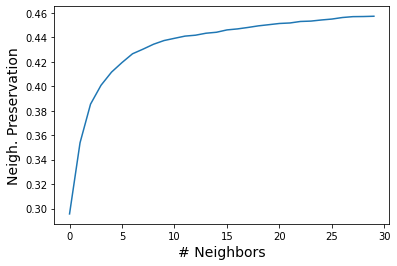

In [49]:
cluster_level = X[analysis_cluster0.landmark_orig_indexes,:]
cluster_embedding = analysis_cluster0.embedding

indices_cluster = random.sample(range(0, len(cluster_embedding)), min(5000, len(cluster_embedding)))

cluster_embedding = cluster_embedding[indices_cluster]
cluster_level = cluster_level[indices_cluster]

print("stress: ", stress(cluster_level, cluster_embedding))
print("demap: ", demap.DEMaP(cluster_level, cluster_embedding))
print("pearsonr: ", correlation(cluster_level, cluster_embedding))

ks = 30

npres = neighborhood_preservation(cluster_level, cluster_embedding, Khigh=ks)
print(npres)
plt.plot(np.arange(ks), npres)
plt.xlabel("# Neighbors", fontsize=14)
plt.ylabel("Neigh. Preservation", fontsize=14)
plt.savefig("figs/"+dataset+"-hsne-expand3-np.png")
plt.show()